In [1]:
#Title: Energy forecasting using LSTM Networks
#Author: Arslan Ahmed (arslan.m.ahmed@gmail.com)
#Date: 2nd March, 2018

#import all packages that we may need

import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.cross_validation import KFold # use for cross validation
from sklearn import preprocessing # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import ExtraTreesClassifier

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
from pandas import concat
import matplotlib.dates as md

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#function to convert time series data to apply supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [3]:
#read energy data

df_e = pd.read_csv('UKdata_energy.csv', parse_dates={'time_e' : ['Time']}, infer_datetime_format=True, na_values=['nan','?'], index_col='time_e')

In [4]:
#read weather data

df_w = pd.read_csv('UKdata_weather.csv', parse_dates={'time_w' : ['time']}, infer_datetime_format=True, na_values=['nan','?'], index_col='time_w')

In [5]:
#select data from 1st Jan 2013 to 28th Feb 2014
df_e=df_e['2013-01-01':'2014-02-28']
df_w=df_w['2013-01-01':'2014-02-28']

In [6]:
df_w=df_w.resample('3H').mean()
df_e=df_e.resample('3H').mean()

In [7]:
print(df_w.shape)
print(df_e.shape)

(3392, 8)
(3385, 3)


In [8]:
df = pd.concat([df_e, df_w], axis=1, join='inner')

In [9]:
df=df.interpolate(method='linear')

In [10]:
df['Day of week'] = df.index.weekday.astype(int)
df["Weekend"] = (df["Day of week"] > 5).astype(int)
df.iloc[:,0:3] *= 1000

In [11]:
#display first five rows
df.head()

,D0009,D0664,D0935,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,Day of week,Weekend
2013-01-01 00:00:00,56.166667,138.833333,133.000000,13.290000,272.000000,7.220000,2.353333,1008.803333,3.880000,5.570000,0.710000,1,0
2013-01-01 03:00:00,70.500000,137.500000,104.000000,13.073333,262.000000,6.510000,1.750000,1010.790000,3.456667,4.516667,0.716667,1,0
2013-01-01 06:00:00,90.833333,178.000000,186.833333,13.340000,258.333333,5.510000,1.913333,1013.360000,2.006667,4.930000,0.776667,1,0
2013-01-01 09:00:00,55.500000,135.833333,254.000000,13.700000,260.666667,5.006667,2.023333,1016.133333,1.770000,4.170000,0.810000,1,0
2013-01-01 12:00:00,54.166667,129.833333,206.166667,13.206667,251.000000,3.773333,2.080000,1018.426667,0.530000,3.733333,0.886667,1,0


In [12]:
no_of_features=len(df.columns)

In [13]:
#describe the data to see mean, std, percentiles etc..
df.describe()

,D0009,D0664,D0935,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,Day of week,Weekend
count,3385.000000,3385.000000,3385.000000,3385.000000,3385.000000,3385.000000,3385.000000,3385.000000,3385.000000,3385.000000,3385.000000,3385.000000,3385.000000
mean,220.246785,279.687331,173.942058,11.270824,190.756622,10.280656,6.124469,1013.287492,8.837454,4.032680,0.770591,2.993205,0.141802
std,170.735570,183.810027,122.070724,2.996826,89.123556,6.152221,5.407566,11.094018,7.452045,2.060805,0.137637,1.995921,0.348899
min,29.833333,53.333333,55.333333,0.536667,1.666667,-3.706667,-8.600000,976.476667,-8.516667,0.216667,0.243333,0.000000,0.000000
25%,123.833333,129.333333,92.666667,10.193333,113.000000,5.646667,2.100000,1006.350000,3.013333,2.520000,0.690000,1.000000,0.000000
50%,172.666667,239.500000,152.166667,12.173333,214.000000,9.410000,6.001770,1013.933333,7.856667,3.823333,0.796667,3.000000,0.000000
75%,260.666667,386.666667,205.833333,13.160000,250.000000,14.673333,10.270000,1021.190000,14.673333,5.270000,0.880000,5.000000,0.000000
max,1699.333333,1293.500000,963.000000,16.090000,358.333333,32.050000,18.696667,1040.070000,32.193333,14.203333,0.996667,6.000000,1.000000


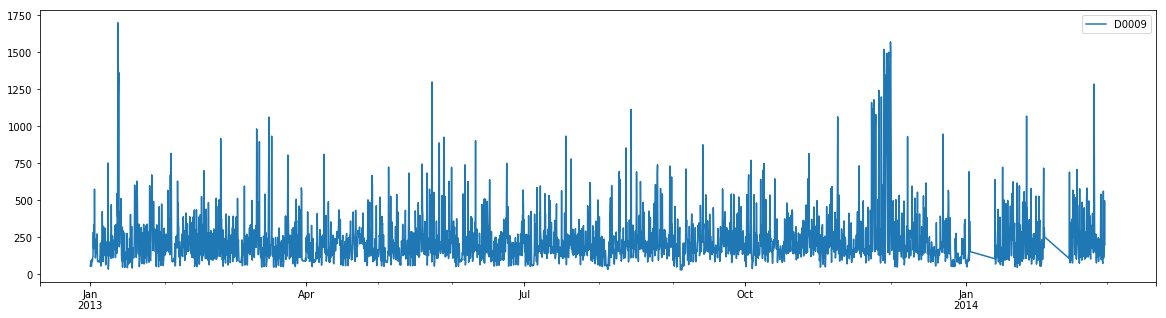

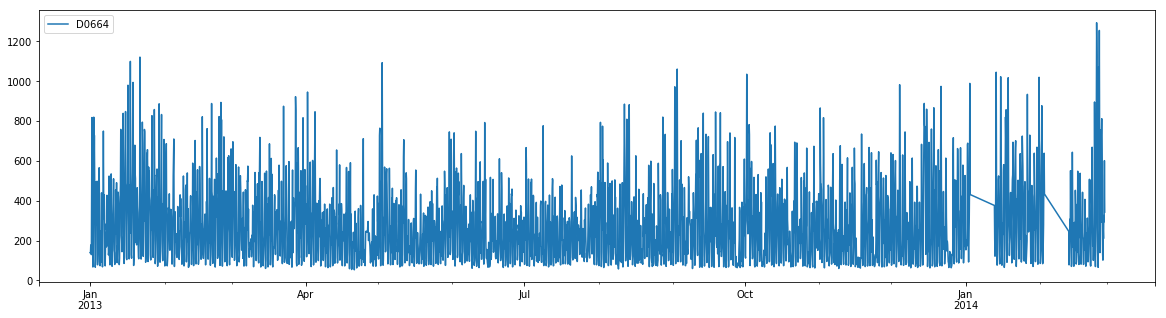

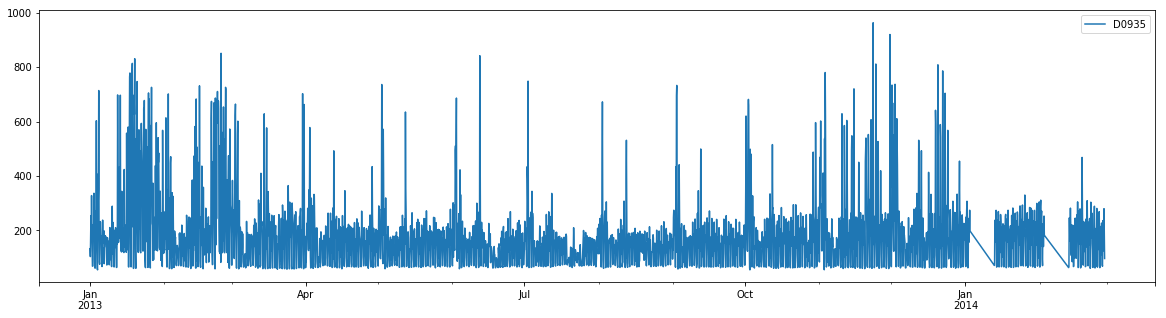

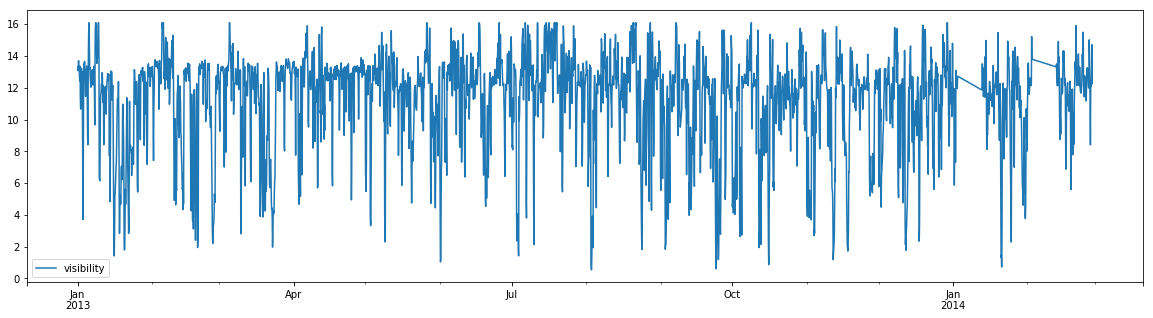

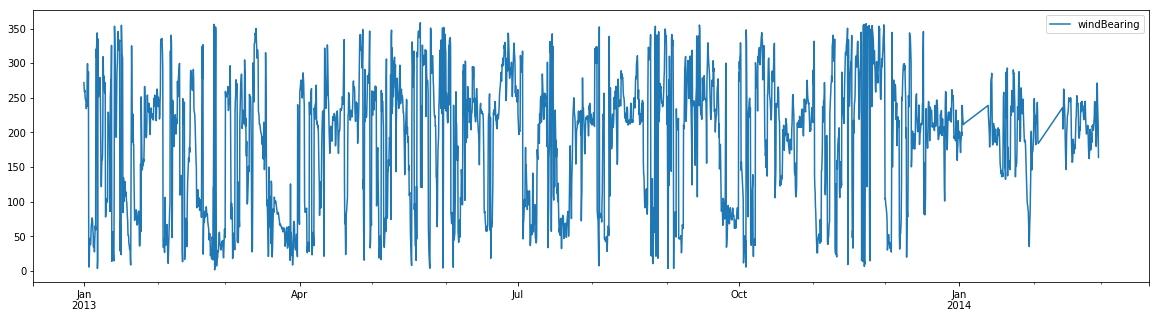

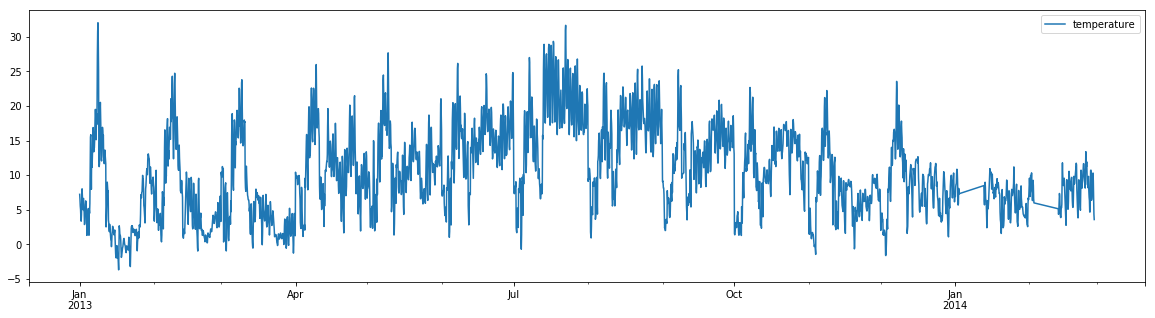

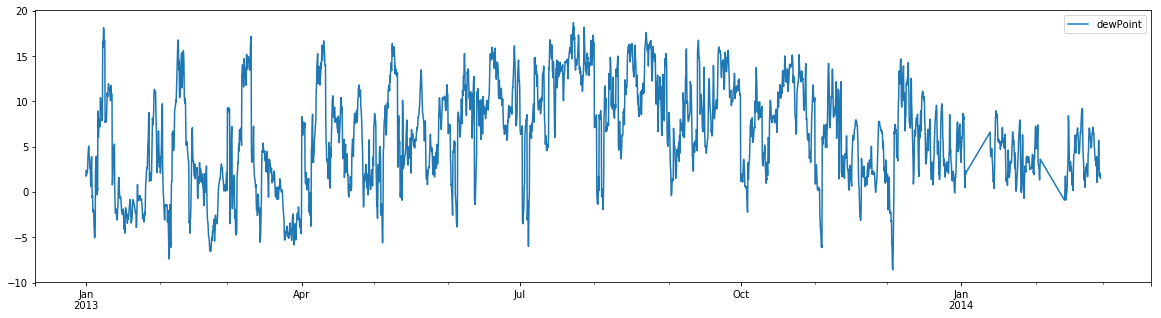

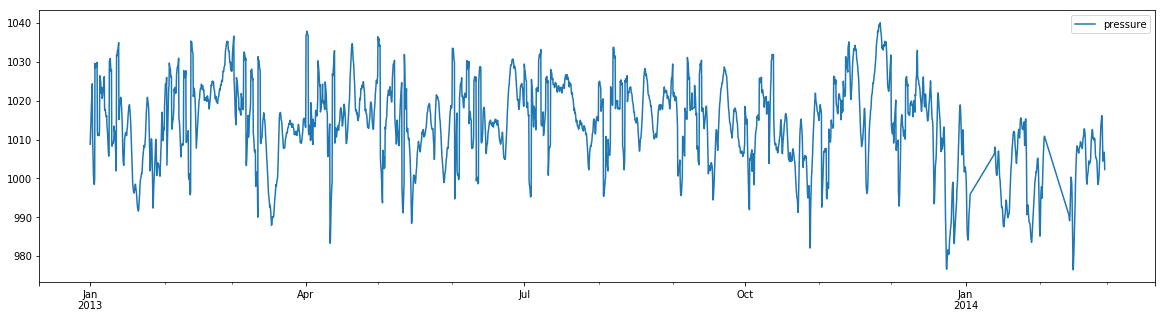

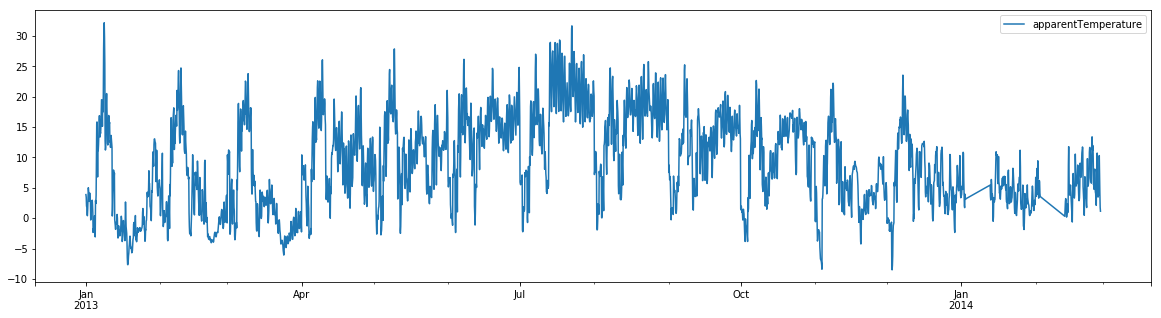

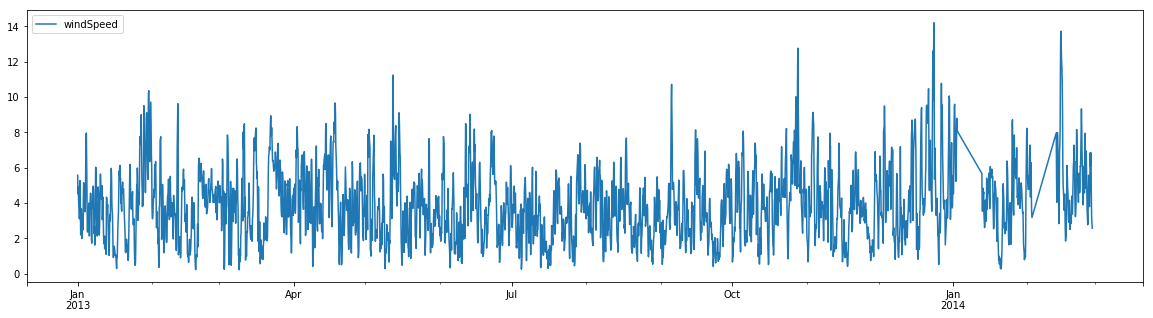

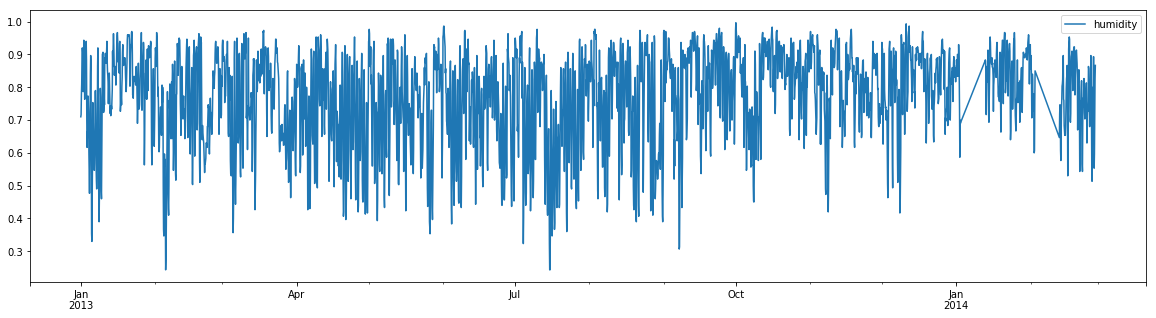

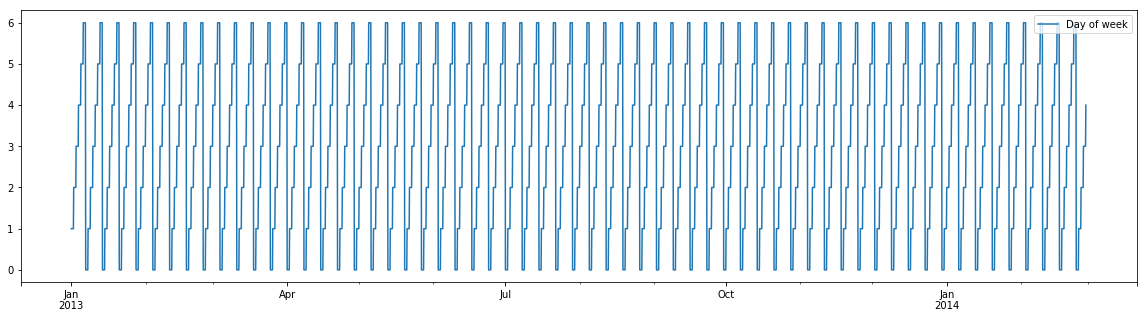

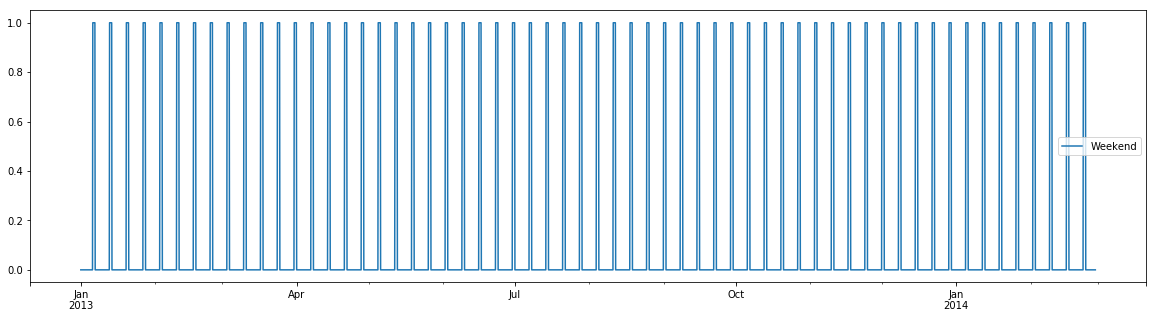

In [14]:
#plotting all columns with respect to time for original data
for j in range(0,no_of_features):        
        plt.figure(figsize=(20,5))
        df.iloc[:,j].plot(legend=True)

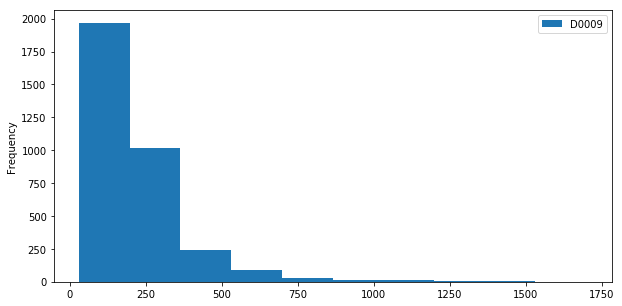

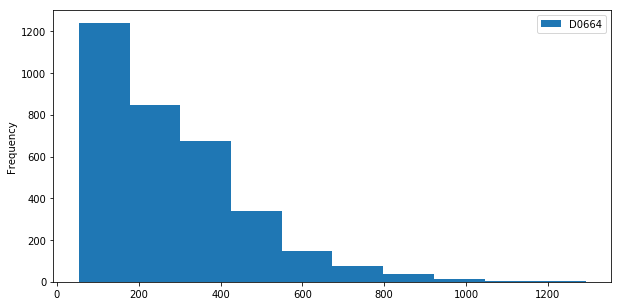

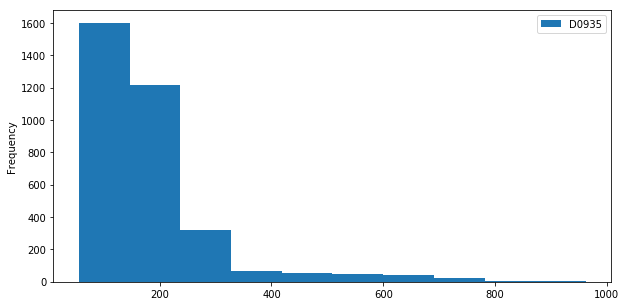

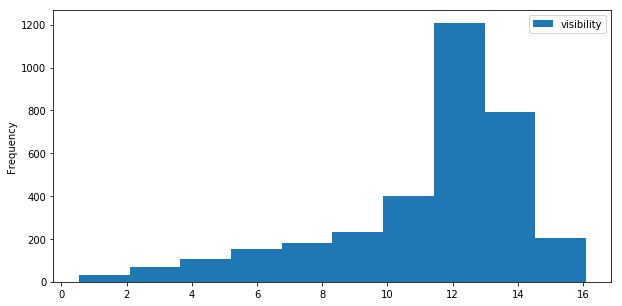

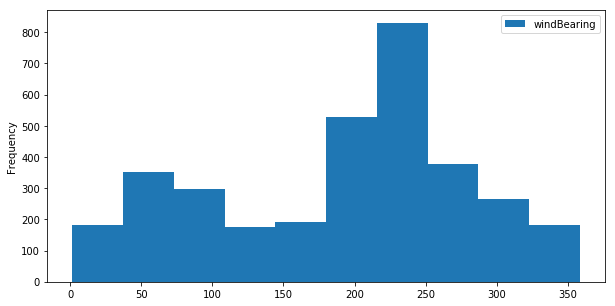

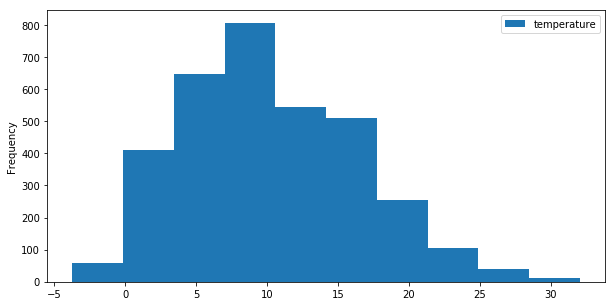

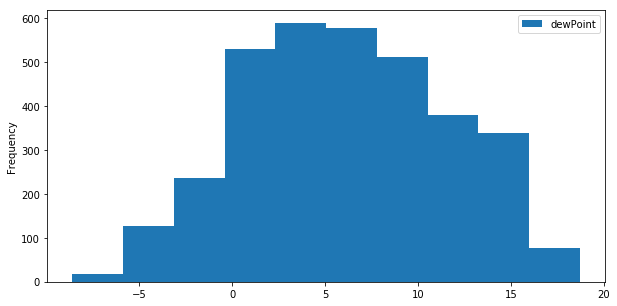

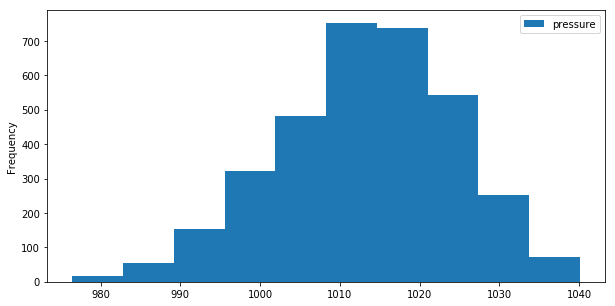

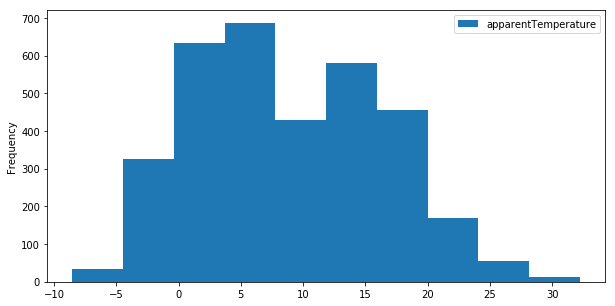

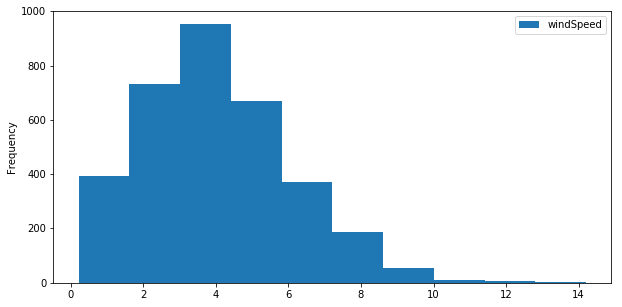

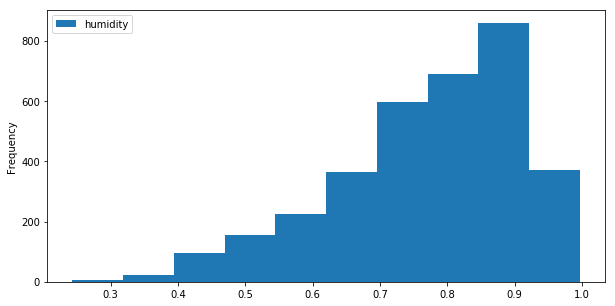

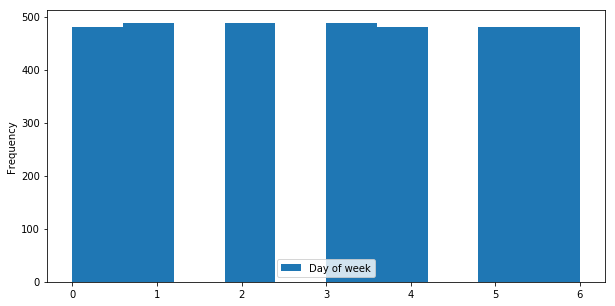

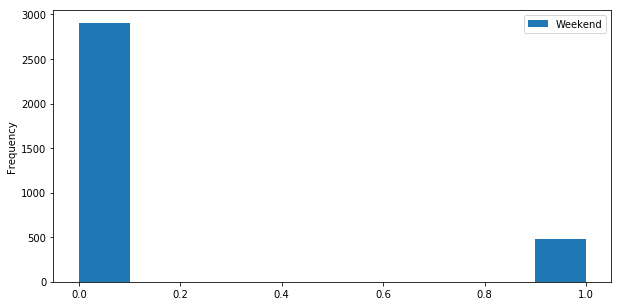

In [15]:
#histograom of original data

for j in range(0,no_of_features):        
        plt.figure(figsize=(10,5))
        df[df.columns[j]].plot.hist(legend=True)    

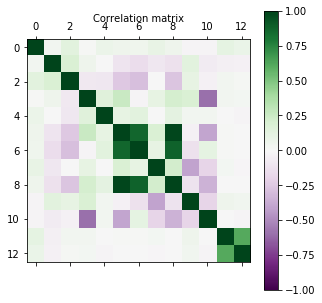

In [16]:
# Correlations matrix of original data
plt.figure(figsize=(5,5))
plt.matshow(df.corr(method='pearson'),vmax=1,vmin=-1,cmap='PRGn', fignum=1)
plt.title('Correlation matrix', size=10)
plt.colorbar()
plt.show()

In [17]:
#removing outliers
df[df.D0009 > df.D0009.quantile(.9)]=np.nan #data above 90 percentile will be filled with NaN
df[df.D0664 > df.D0664.quantile(.9)]=np.nan
df[df.D0935 > df.D0935.quantile(.9)]=np.nan
df=df.fillna(method='pad')

In [18]:
# another sanity check to make sure that there are no nan
df.isnull().sum()

D0009                  0
D0664                  0
D0935                  0
visibility             0
windBearing            0
temperature            0
dewPoint               0
pressure               0
apparentTemperature    0
windSpeed              0
humidity               0
Day of week            0
Weekend                0
dtype: int64

In [19]:
df.describe()

,D0009,D0664,D0935,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,Day of week,Weekend
count,3385.000000,3385.000000,3385.000000,3385.000000,3385.000000,3385.000000,3385.000000,3385.000000,3385.000000,3385.000000,3385.000000,3385.000000,3385.000000
mean,171.016928,227.411940,138.420286,11.184659,191.352585,10.140002,6.083046,1013.316516,8.681727,3.983264,0.775600,2.989956,0.141507
std,78.592252,128.869599,57.208388,3.049931,89.371160,6.235210,5.404117,11.031165,7.520328,2.034565,0.136740,1.991980,0.348595
min,29.833333,53.333333,55.333333,0.536667,3.666667,-3.233333,-6.566667,976.476667,-8.516667,0.246667,0.243333,0.000000,0.000000
25%,114.500000,109.000000,81.833333,10.090000,112.333333,5.443333,2.053333,1006.416667,2.700000,2.533333,0.700000,1.000000,0.000000
50%,152.333333,203.000000,135.000000,12.130000,215.000000,9.373333,5.960000,1013.893333,7.690000,3.770000,0.803333,3.000000,0.000000
75%,218.166667,334.000000,180.833333,13.153333,250.333333,14.646667,10.260000,1021.220000,14.646667,5.220000,0.880000,5.000000,0.000000
max,393.666667,522.500000,262.666667,16.090000,357.000000,32.050000,18.696667,1040.070000,32.193333,14.203333,0.996667,6.000000,1.000000


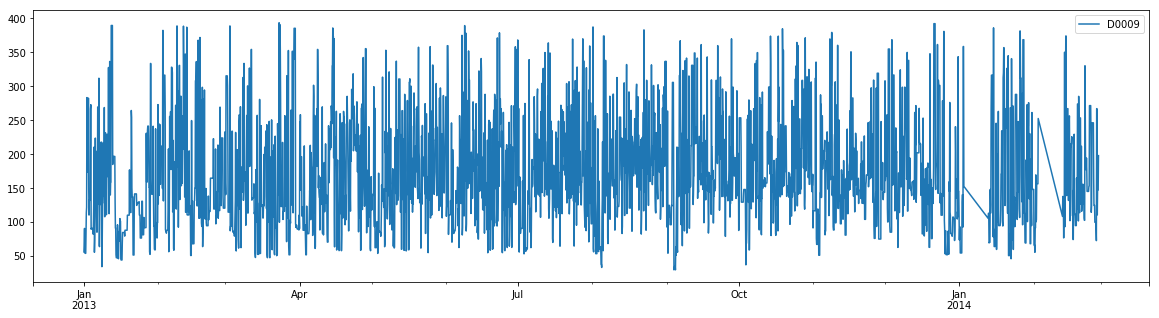

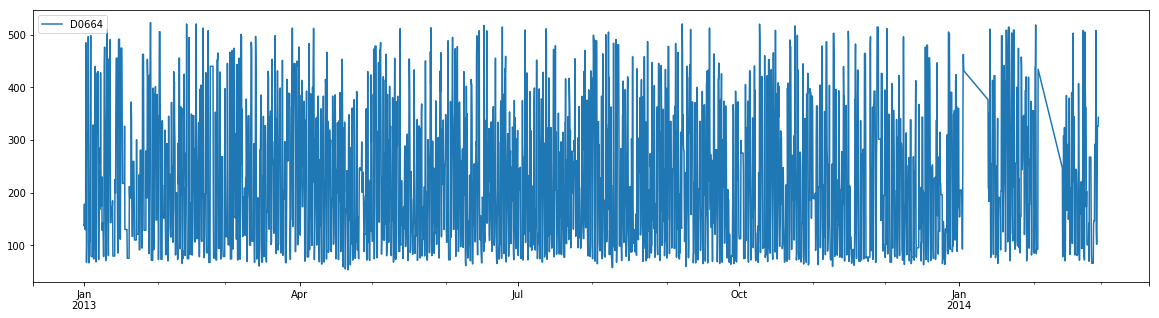

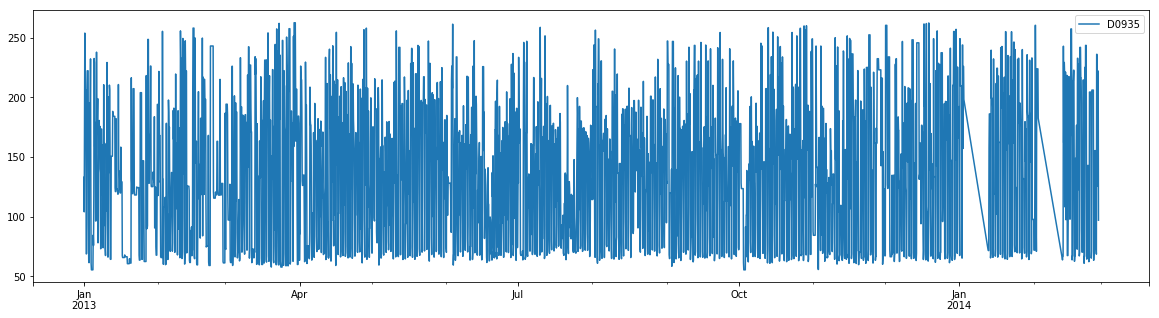

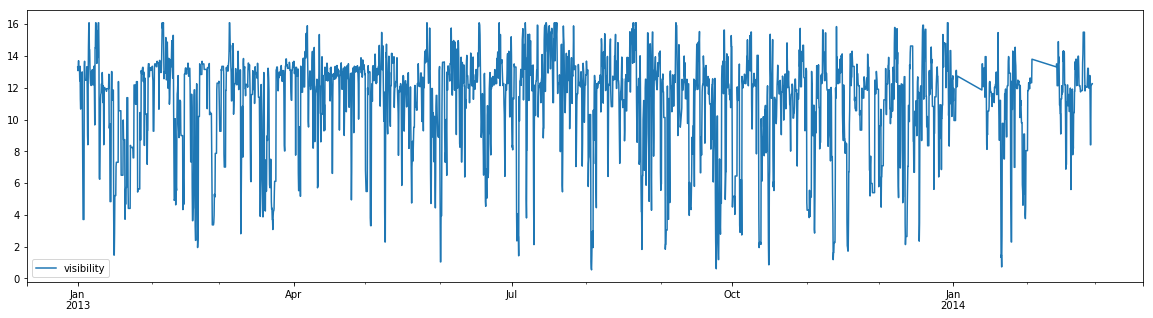

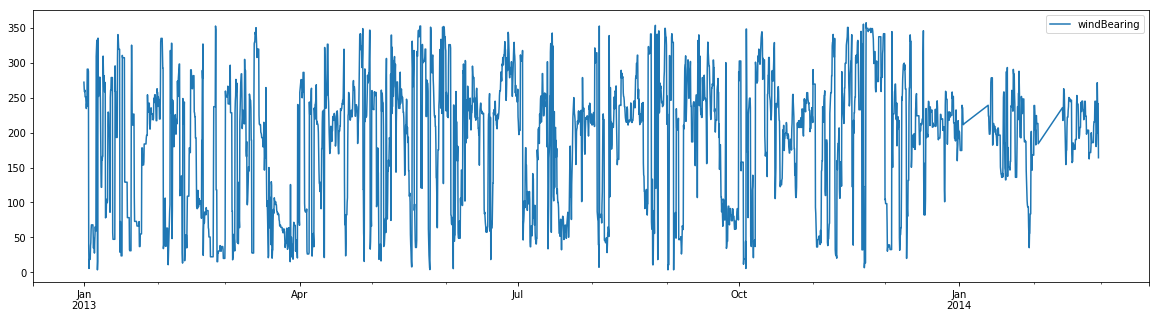

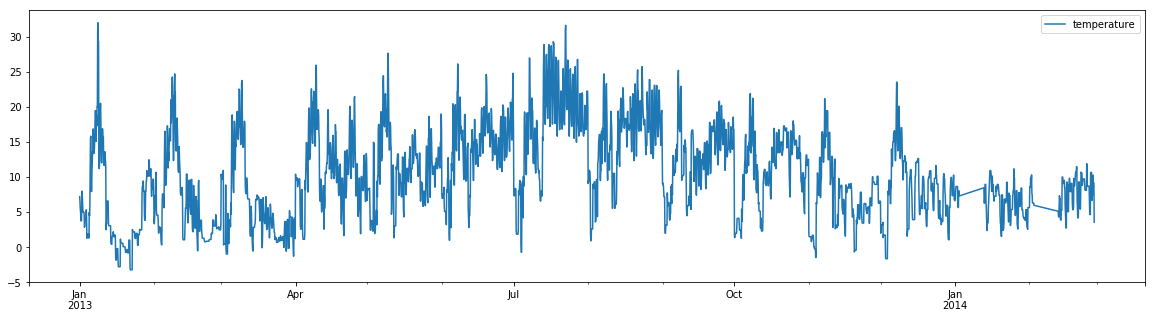

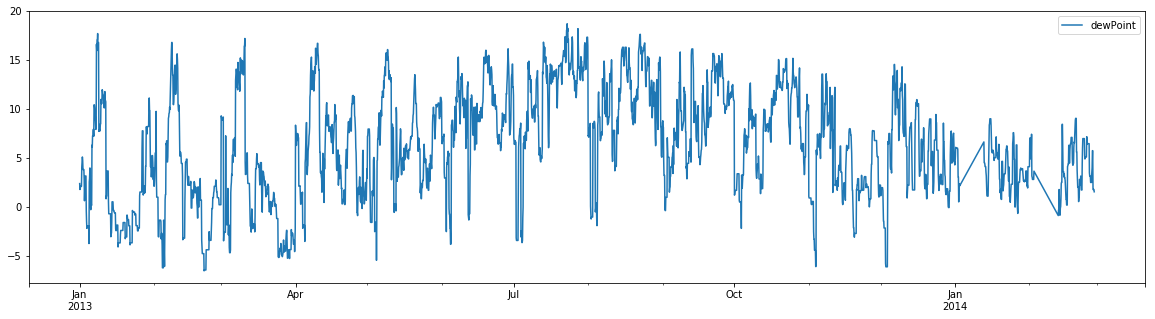

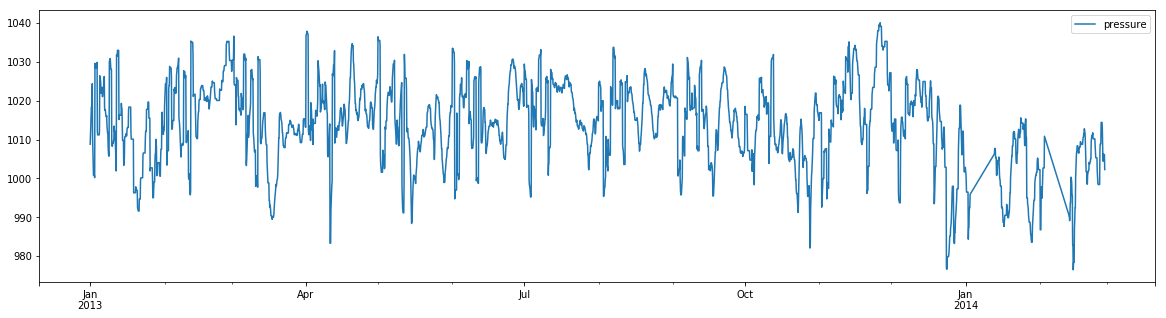

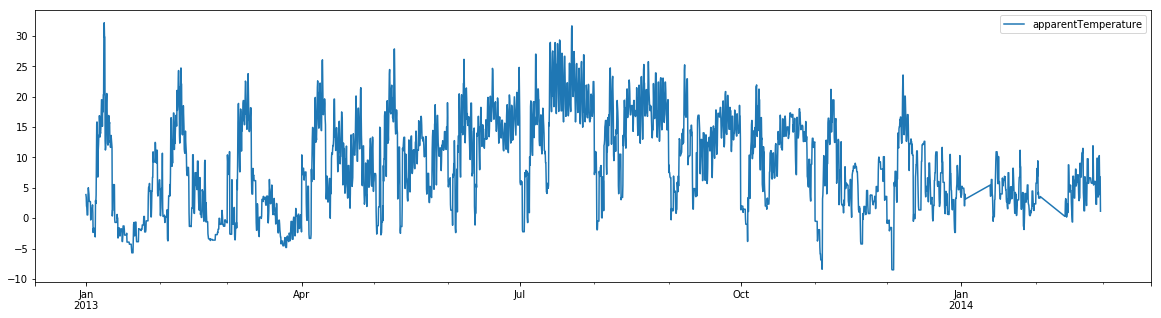

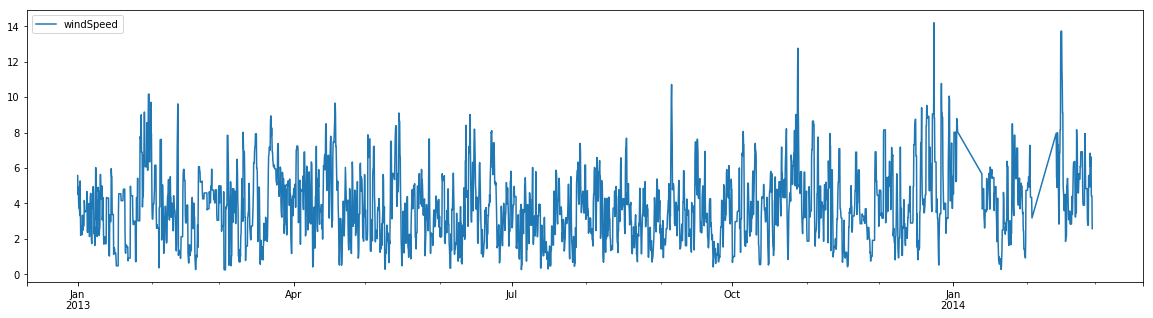

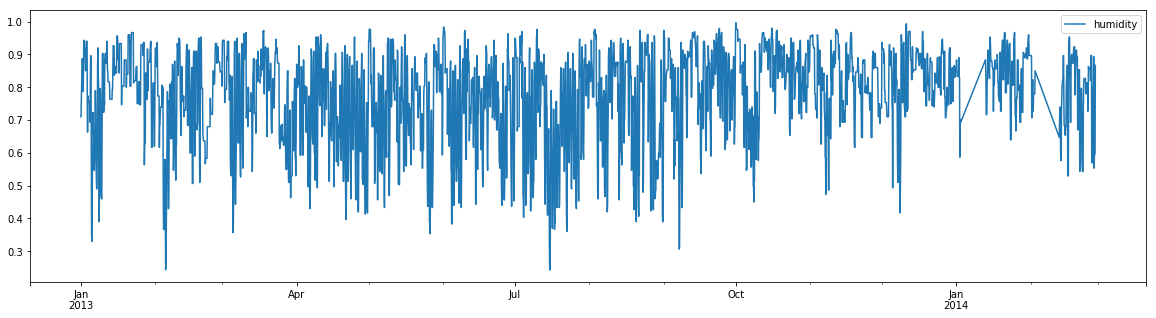

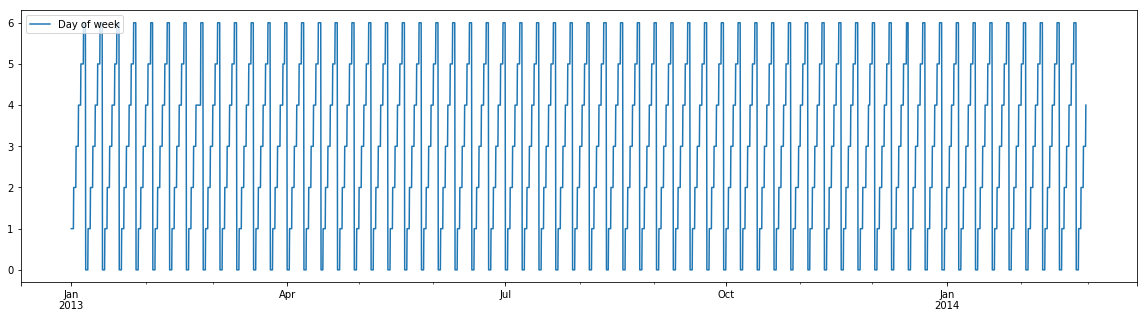

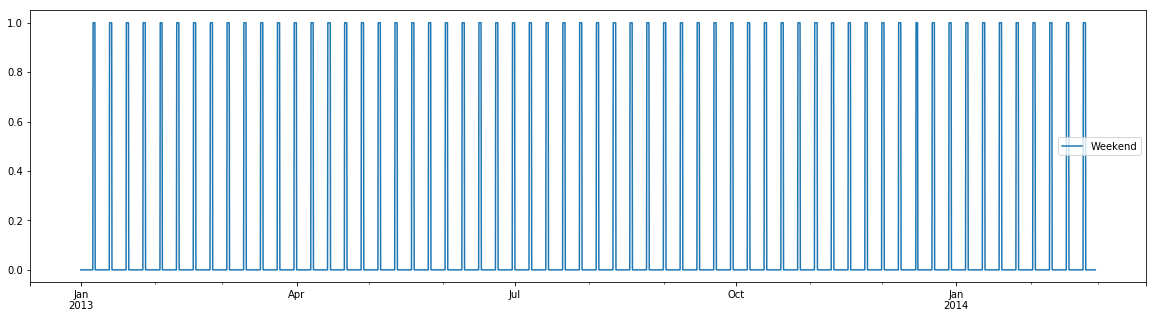

In [20]:
#plotting all columns with respect to time after removing outliers and missing values
for j in range(0,no_of_features):        
        plt.figure(figsize=(20,5))
        df.iloc[:,j].plot(legend=True)

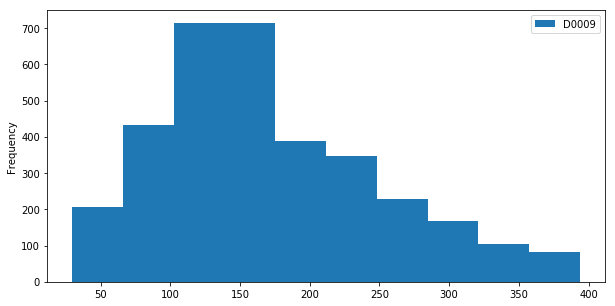

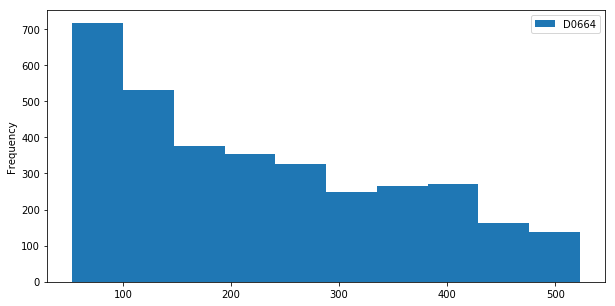

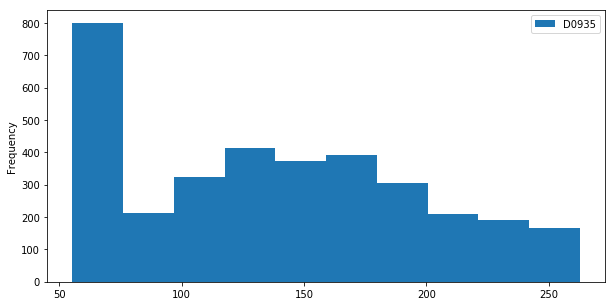

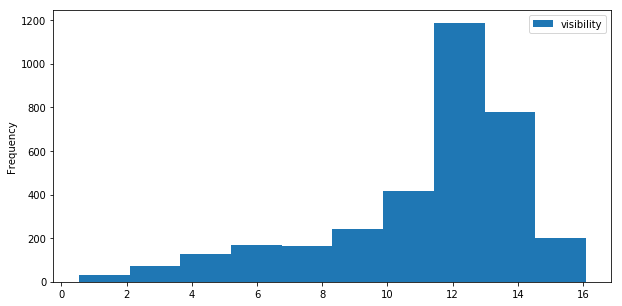

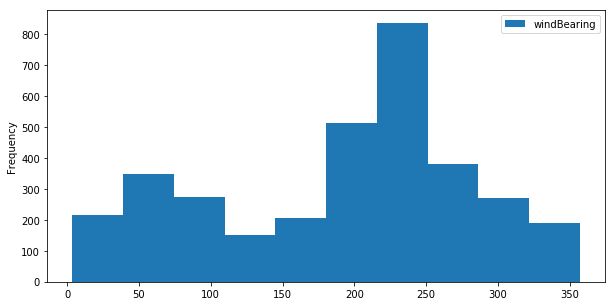

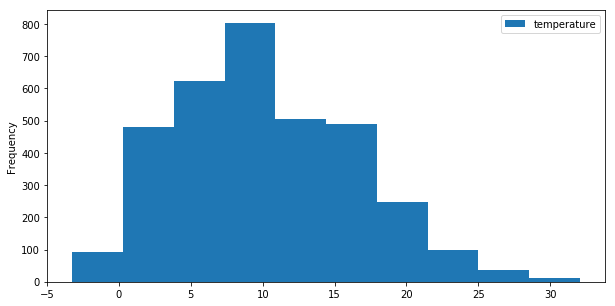

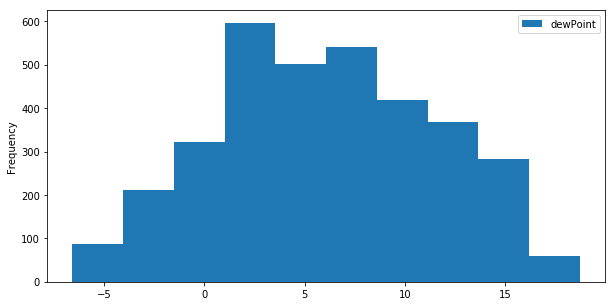

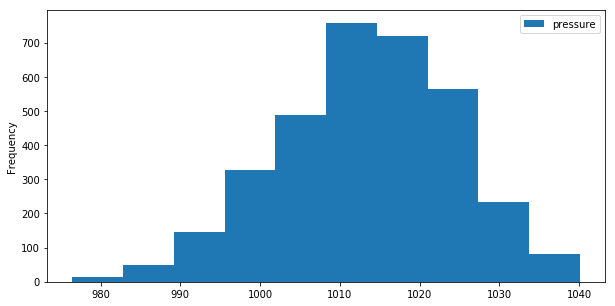

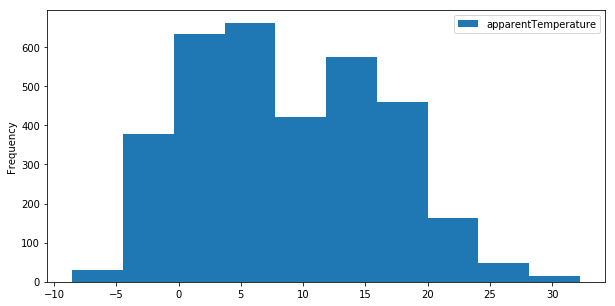

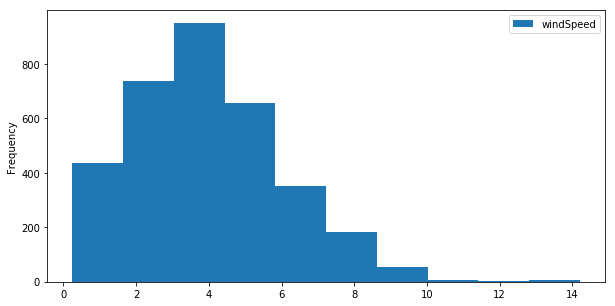

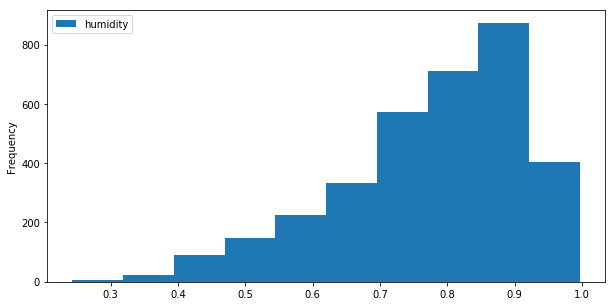

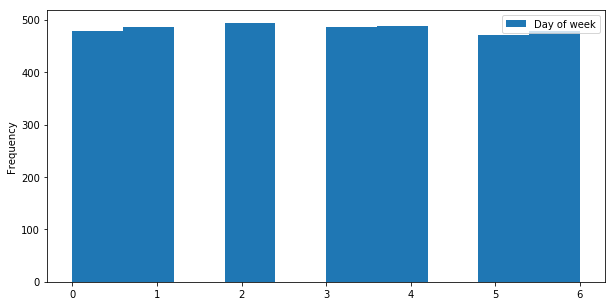

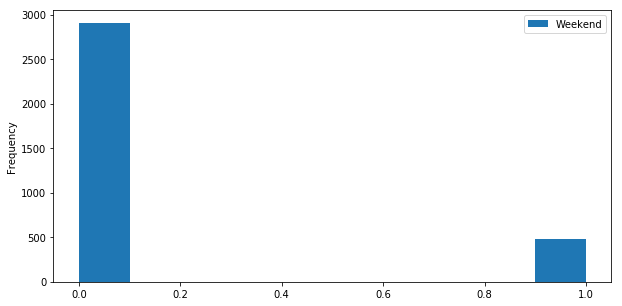

In [21]:
#histogram for data after removing outliers and missing values
for j in range(0,no_of_features):        
        plt.figure(figsize=(10,5))
        df[df.columns[j]].plot.hist(legend=True)    

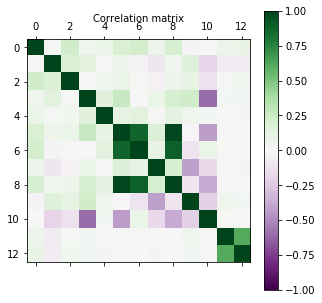

In [22]:
# Correlations matrix of data with removed outliers and missing values
plt.figure(figsize=(5,5))
plt.matshow(df.corr(method='pearson'),vmax=1,vmin=-1,cmap='PRGn', fignum=1)
plt.title('Correlation matrix', size=10)
plt.colorbar()
plt.show()

In [23]:
model_tree = ExtraTreesClassifier()
alpha=df.iloc[:,1:]
beta=df.iloc[:,0].astype(int)

In [24]:
model_tree.fit(alpha, beta)
print(model_tree.feature_importances_)

[0.09497179 0.09482973 0.09249853 0.09477031 0.09245048 0.09219106
 0.10133259 0.08727757 0.09497575 0.09150864 0.0591519  0.00404166]


In [25]:
#drop features that are correlated with each other
df=df.drop(df.columns[[8,10,11,12]], axis=1)
#df=df.drop(df.columns[1:], axis=1)

In [26]:
#revised no. of features after dropping correlated features
no_of_features=len(df.columns)

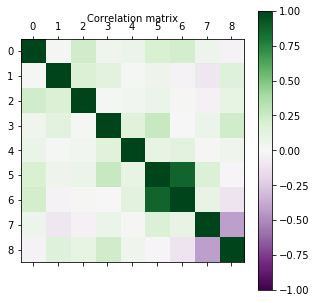

In [27]:
# Correlations matrix of data after dropping correlated features
plt.figure(figsize=(5,5))
plt.matshow(df.corr(method='pearson'),vmax=1,vmin=-1,cmap='PRGn', fignum=1)
plt.title('Correlation matrix', size=10)
plt.colorbar()
plt.show()

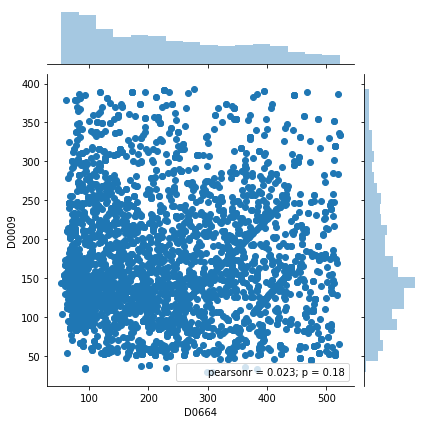

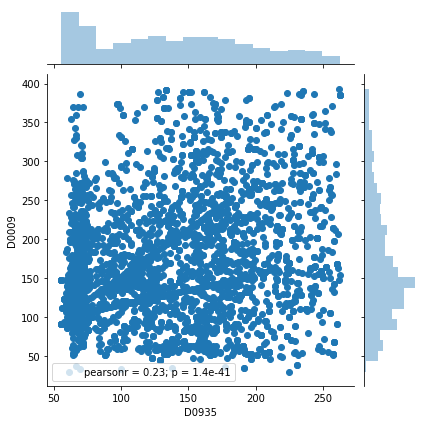

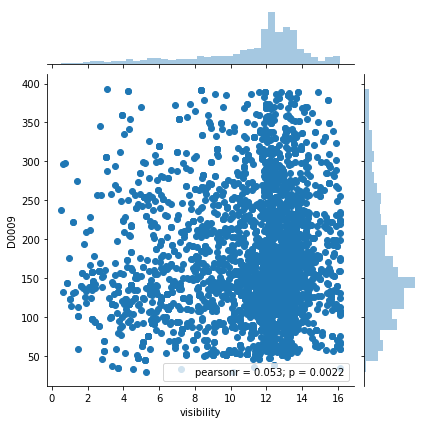

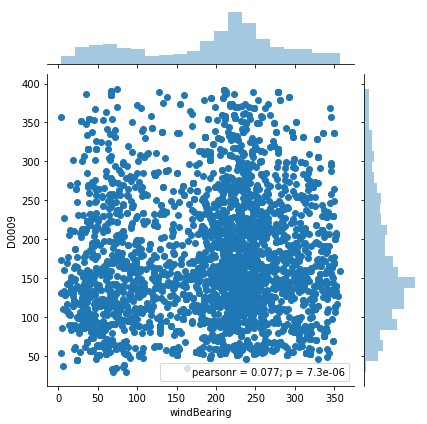

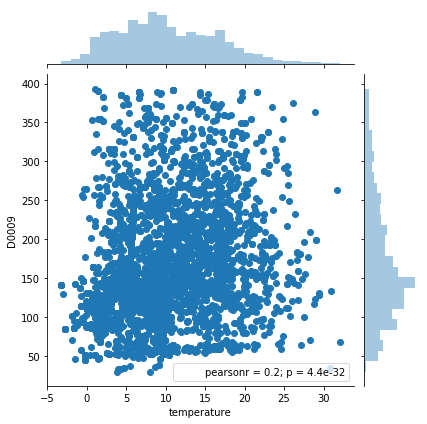

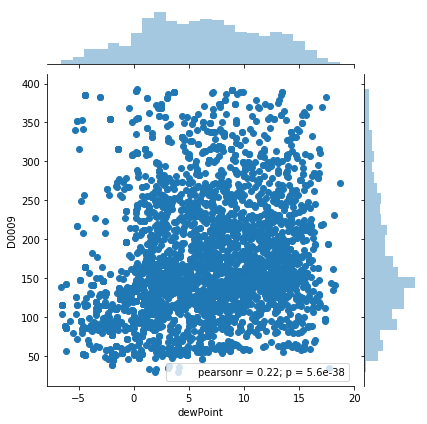

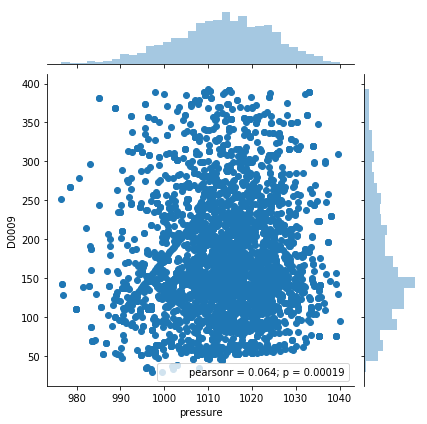

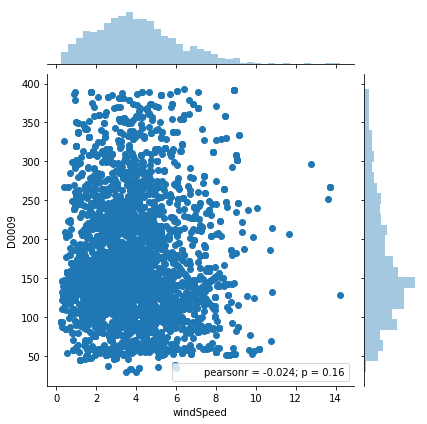

In [28]:
#corelation of all the features (on x-axis) with the target variable Energy (on y-axis) - after removing outliers and missing values
for j in range(1,no_of_features):
    sns.jointplot(x=df.columns[j],y=df.columns[0],data=df)

In [29]:
#data scaling from 0 to 1 of original data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)

In [30]:
no_of_timesteps=1
reframed = series_to_supervised(scaled, no_of_timesteps, 1)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.072377   0.182238   0.374598   0.819974   0.759434   0.296268   
2   0.111773   0.179396   0.234727   0.806044   0.731132   0.276145   
3   0.167659   0.265719   0.634244   0.823189   0.720755   0.247803   
4   0.070545   0.175844   0.958199   0.846335   0.727358   0.233538   
5   0.066880   0.163055   0.727492   0.814616   0.700000   0.198583   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)   var2(t)   var3(t)   var4(t)  \
1   0.353081   0.508334   0.381419  0.111773  0.179396  0.234727  0.806044   
2   0.329199   0.539574   0.305947  0.167659  0.265719  0.634244  0.823189   
3   0.335664   0.579987   0.335562  0.070545  0.175844  0.958199  0.846335   
4   0.340018   0.623598   0.281108  0.066880  0.163055  0.727492  0.814616   
5   0.342262   0.659660   0.249821  0.066880  0.163055  0.727492  0.814616   

    var5(t)   var6(t)   var7(t)   var8(t)   var9(t)  
1  0.731132  0.276145  0.329199  0.539574  0.30594

In [31]:
# drop columns we don't want to predict
col_array=np.arange(0,len(reframed.columns))
reframed=reframed.loc[:,(col_array<no_of_features*no_of_timesteps+1) | (col_array%(no_of_features)==0)]

In [32]:
print(reframed.head())
print(reframed.shape)

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.072377   0.182238   0.374598   0.819974   0.759434   0.296268   
2   0.111773   0.179396   0.234727   0.806044   0.731132   0.276145   
3   0.167659   0.265719   0.634244   0.823189   0.720755   0.247803   
4   0.070545   0.175844   0.958199   0.846335   0.727358   0.233538   
5   0.066880   0.163055   0.727492   0.814616   0.700000   0.198583   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.353081   0.508334   0.381419  0.111773  
2   0.329199   0.539574   0.305947  0.167659  
3   0.335664   0.579987   0.335562  0.070545  
4   0.340018   0.623598   0.281108  0.066880  
5   0.342262   0.659660   0.249821  0.066880  
(3384, 10)


In [33]:
n_train_time = 8*30*11; # hours used for training
original_n_train_time=n_train_time;
pred_list=[]; #predicted values that will replace the original test_y values
testing_rows=8*30;#hours to predict
#testing_rows=reframed.shape[0]-original_n_train_time-1
test1 = reframed.values[n_train_time:n_train_time+testing_rows, :] #original testing data, this will later be modified with the predicted data generated by for loop
test_y1 = test1[:, -1] #see comment in above line

In [34]:
train = reframed.values[:n_train_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], no_of_timesteps, no_of_features))
print(train_X.shape)

(2640, 1, 9)


In [35]:
#LSTM model
model = Sequential()
model.add(LSTM(500, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
# model.add(LSTM(50,return_sequences=True))
# model.add(Dropout(0.2))
# model.add(Dense(1))
# model.add(LSTM(20,return_sequences=True))
# model.add(Dropout(0.2))
# model.add(Dense(1))
# model.add(LSTM(10,return_sequences=True))
# model.add(Dropout(0.2))
# model.add(Dense(1))

model.add(LSTM(500))



# model.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
adam = keras.optimizers.Adamax(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=24, verbose=2, shuffle=True)

Epoch 1/20
 - 7s - loss: 0.0568
Epoch 2/20
 - 6s - loss: 0.0388
Epoch 3/20
 - 5s - loss: 0.0374
Epoch 4/20
 - 5s - loss: 0.0368
Epoch 5/20
 - 5s - loss: 0.0372
Epoch 6/20
 - 5s - loss: 0.0375
Epoch 7/20
 - 5s - loss: 0.0365
Epoch 8/20
 - 5s - loss: 0.0367
Epoch 9/20
 - 5s - loss: 0.0365
Epoch 10/20
 - 6s - loss: 0.0367
Epoch 11/20
 - 5s - loss: 0.0371
Epoch 12/20
 - 5s - loss: 0.0365
Epoch 13/20
 - 5s - loss: 0.0366
Epoch 14/20
 - 6s - loss: 0.0370
Epoch 15/20
 - 6s - loss: 0.0364
Epoch 16/20
 - 6s - loss: 0.0365
Epoch 17/20
 - 6s - loss: 0.0361
Epoch 18/20
 - 6s - loss: 0.0363
Epoch 19/20
 - 6s - loss: 0.0362
Epoch 20/20
 - 6s - loss: 0.0363


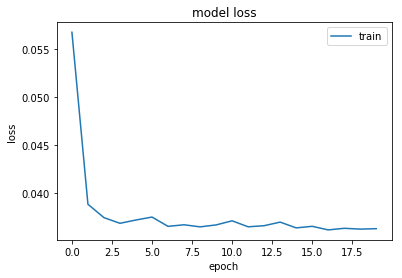

In [36]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [37]:
for j in range(0,testing_rows):
    print('Loop # ',j)
    test = reframed.values[n_train_time:n_train_time+1, :]
    test_X = test[:, :-1]
    test_X = test_X.reshape((test_X.shape[0], no_of_timesteps, no_of_features))
    yhat = model.predict(test_X,batch_size=2*24)
#     for k in range(0,len(reframed.columns),no_of_features):
#         if((k+no_of_features)<(len(reframed.columns)-1)):
#             reframed.values[n_train_time+1,k]=reframed.values[n_train_time,(k+no_of_features)];
#     reframed.values[n_train_time+1,(len(reframed.columns)-1-no_of_features)]=yhat;
    reframed.values[n_train_time+1,0]=yhat;
    n_train_time=n_train_time+1
    pred_list=np.append(pred_list,yhat)
    print(reframed[n_train_time-1:n_train_time])
    print(yhat)
n_train_time=original_n_train_time

Loop #  0
      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
2641   0.285387   0.530373   0.038585   0.632662   0.737736   0.260274   

      var7(t-1)  var8(t-1)  var9(t-1)  var1(t)  
2641   0.394379   0.927089   0.133508  0.31333  
[[0.3334081]]
Loop #  1
      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
2642   0.333408   0.030195   0.054662   0.402915   0.720755   0.258762   

      var7(t-1)  var8(t-1)  var9(t-1)  var1(t)  
2642   0.432115   0.904445   0.123716  0.31333  
[[0.39152116]]
Loop #  2
      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
2643   0.391521   0.030195   0.054662   0.402915   0.720755   0.258762   

      var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
2643   0.432115   0.904445   0.123716  0.736143  
[[0.41495112]]
Loop #  3
      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
2644   0.414951   0.276377   0.573955   0.298971   0.806604   0.320831   

      var7(t-1)  var8(t-

      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
2677   0.396072    0.10444    0.98955   0.581869   0.267925   0.181483   

      var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
2677    0.33672   0.562061   0.322427  0.381585  
[[0.40026352]]
Loop #  37
      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
2678   0.400264    0.10444    0.98955   0.581869   0.267925   0.181483   

      var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
2678    0.33672   0.562061   0.322427  0.381585  
[[0.40197334]]
Loop #  38
      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
2679   0.401973    0.10444    0.98955   0.581869   0.267925   0.181483   

      var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
2679    0.33672   0.562061   0.322427  0.627577  
[[0.40267003]]
Loop #  39
      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
2680    0.40267   0.976199   0.652733   0.649807   0.186792   0.192348   

      var7(t-1)  var8(t-1)

      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
2708   0.446421   0.137833   0.831994   0.804972   0.751887   0.333302   

      var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
2708    0.42433   0.616836    0.36685  0.574439  
[[0.45856386]]
Loop #  68
      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
2709   0.458564   0.146004   0.554662   0.746678   0.699057   0.488994   

      var7(t-1)  var8(t-1)  var9(t-1)  var1(t)  
2709   0.395963   0.618513   0.439217  0.47366  
[[0.48368862]]
Loop #  69
      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
2710   0.483689   0.319005   0.854502   0.652593   0.608491   0.424185   

      var7(t-1)  var8(t-1)  var9(t-1)  var1(t)  
2710   0.571447   0.599277   0.337712  0.47366  
[[0.47616923]]
Loop #  70
      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
2711   0.476169   0.319005   0.854502   0.652593   0.608491   0.424185   

      var7(t-1)  var8(t-1)  va

      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
2741   0.471825   0.261101    0.32074   0.745392   0.732075   0.575154   

      var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
2741   0.759995   0.676643   0.128732  0.620247  
[[0.4793662]]
Loop #  101
      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
2742   0.479366   0.261101    0.32074   0.745392   0.732075   0.575154   

      var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
2742   0.759995   0.676643   0.128732  0.620247  
[[0.482138]]
Loop #  102
      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
2743   0.482138   0.261101    0.32074   0.745392   0.732075   0.575154   

      var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
2743   0.759995   0.676643   0.128732  0.537334  
[[0.48315477]]
Loop #  103
      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
2744   0.483155   0.554529   0.046624   0.414702   0.574528   0.527822   

      var7(t-1)  var8(t-1)

      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
2772   0.444681   0.401421    0.43328   0.665238   0.487736   0.405668   

      var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
2772   0.584642   0.677849   0.264151  0.636738  
[[0.43855783]]
Loop #  132
      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
2773   0.438558   0.401421    0.43328   0.665238   0.487736   0.405668   

      var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
2773   0.584642   0.677849   0.264151  0.636738  
[[0.4361309]]
Loop #  133
      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
2774   0.436131   0.401421    0.43328   0.665238   0.487736   0.405668   

      var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
2774   0.584642   0.677849   0.264151  0.505268  
[[0.4351673]]
Loop #  134
      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
2775   0.435167   0.634458   0.673633   0.599871    0.64434   0.368257   

      var7(t-1)  var8(t-1

      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
2802   0.425048   0.020604    0.07717   0.760823   0.382075   0.232026   

      var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
2802   0.382768   0.726124   0.133986  0.367384  
[[0.4008502]]
Loop #  162
      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
2803    0.40085   0.080995   0.995177   0.780969   0.222642    0.22324   

      var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
2803    0.38356   0.739071   0.046334  0.136967  
[[0.39526024]]
Loop #  163
      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
2804    0.39526   0.250089   0.884244   0.695242   0.431132   0.239868   

      var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
2804   0.408893    0.76486   0.040841  0.181402  
[[0.39346704]]
Loop #  164
      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
2805   0.393467   0.310835   0.660772    0.71796   0.222642   0.258479   

      var7(t-1)  var8(t-

      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
2863   0.427859    0.30444   0.878617   0.700171   0.609434   0.347662   

      var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
2863   0.488455   0.053465   0.437067  0.221255  
[[0.4275587]]
Loop #  223
      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
2864   0.427559    0.30444   0.878617   0.700171   0.609434   0.347662   

      var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
2864   0.488455   0.053465   0.437067  0.684379  
[[0.42743802]]
Loop #  224
      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
2865   0.427438   0.024867   0.195338   0.752893   0.611321   0.228153   

      var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
2865   0.388046   0.063005   0.232147  0.298213  
[[0.39274463]]
Loop #  225
      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
2866   0.392745   0.041918   0.278939   0.780754   0.565094   0.208597   

      var7(t-1)  var8(t-

In [38]:
max=351
min=17
test_y1_un_scaled=test_y1*(max-min)+min
pred_list_un_scaled=pred_list*(max-min)+min

RMSE with avg:  0.5137094420113186
RMSE without avg:  79.3851288968302


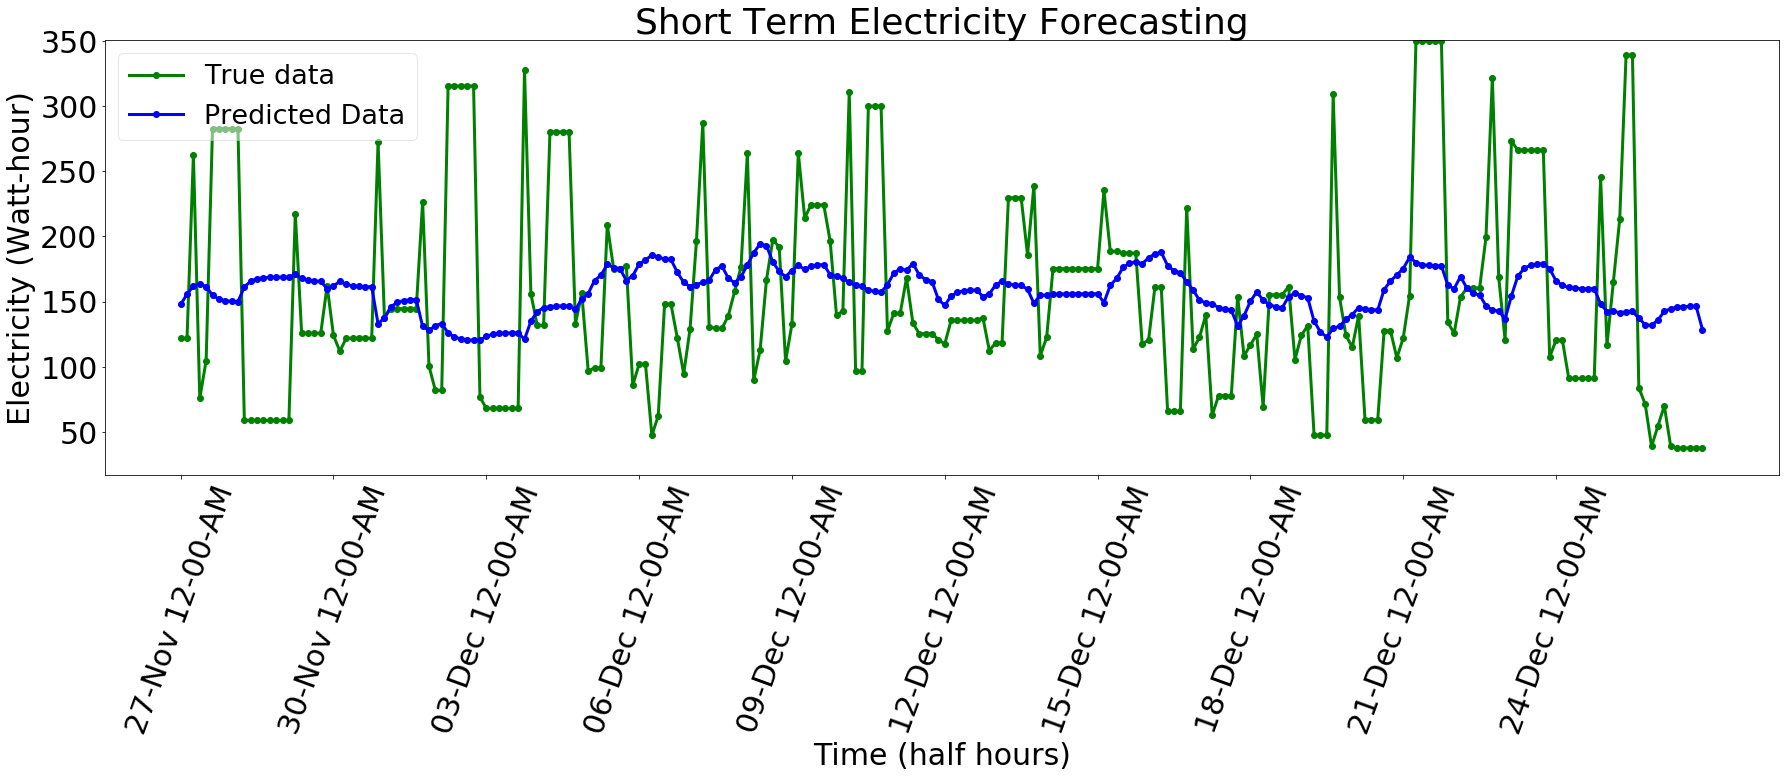

In [39]:
plt.figure(figsize=(30,8))
plt.rcParams.update({'font.size': 30})
plt.plot(test_y1_un_scaled,'go-', label='True data', linewidth=3)
plt.plot(np.roll(pred_list_un_scaled, -1),'bo-',label='Predicted Data', linewidth=3)
plt.ylabel('Electricity (Watt-hour)', fontsize=30)
plt.xlabel('Time (half hours)', fontsize=30)


x=np.arange(0,len(test_y1_un_scaled),24)
y=df.index.strftime('%d-%b %I-%M-%p')[original_n_train_time::24]
plt.xticks(x, y, rotation=70)

plt.ylim(ymin=17,ymax=351)
plt.title('Short Term Electricity Forecasting')
plt.legend(loc='upper left', fontsize=27,framealpha=0.5)
plt.savefig('5a.pdf', bbox_inches='tight')
print ('RMSE with avg: ',(np.sqrt(mean_squared_error(test_y1_un_scaled, np.roll(pred_list_un_scaled, -1))))/np.mean(test_y1_un_scaled))
print ('RMSE without avg: ',(np.sqrt(mean_squared_error(test_y1_un_scaled, np.roll(pred_list_un_scaled, -1)))))

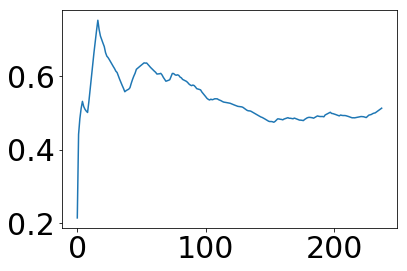

In [40]:
rmse=[];
for e in range(2,len(pred_list_un_scaled)):
    rmse.append((np.sqrt(mean_squared_error(test_y1_un_scaled[1:e], np.roll(pred_list_un_scaled[1:e], -1))))/np.mean(test_y1_un_scaled[1:e]))
#     print ('RMSE for ',e,' predictions: ',)
plt.plot(rmse)

In [41]:
# np.mean(test_y1_un_scaled.reshape(-1, 2), 1)
# np.mean(np.roll(pred_list_un_scaled, -1).reshape(-1, 2), 1) 

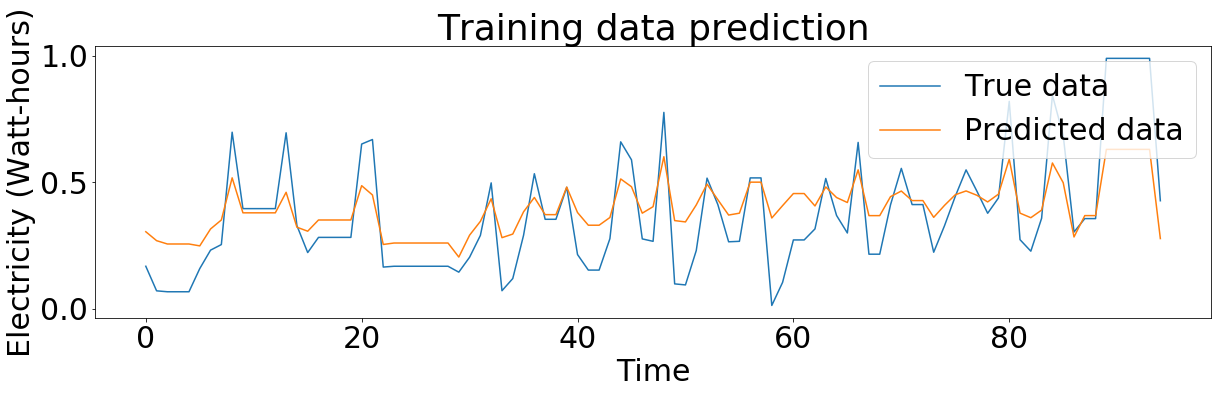

RMSE:  0.32605032472919493
NRMSE:  0.12736903451233822


In [42]:
# Training Data
pred_train_x = model.predict(train_X)
plt.figure(figsize=(20,5)) 
plt.plot(train_y[1:96])
# plt.plot(pred_train_x[1:96])
plt.plot(np.roll(pred_train_x[1:96], -1))
plt.legend(['True data', 'Predicted data'], loc='upper right')
plt.title('Training data prediction')
plt.xlabel('Time')
plt.ylabel('Electricity (Watt-hours)')
plt.show()
print ('RMSE: ', ((np.sqrt(mean_squared_error(train_y, np.roll(pred_train_x, -1))))/np.mean(train_y)))
print ('NRMSE: ', ((np.sqrt(mean_squared_error(train_y, np.roll(pred_train_x, -1))))))

In [43]:
model.get_weights()

[array([[ 0.03392116, -0.41556302, -0.02885088, ..., -0.11586986,
          0.10883436,  0.09271867],
        [ 0.0715151 ,  0.05679055,  0.09766099, ...,  0.04329269,
          0.03012651, -0.00394309],
        [ 0.11693847, -0.09247003, -0.01373335, ..., -0.02382382,
         -0.00764884,  0.01120177],
        ...,
        [-0.06472426, -0.18811873, -0.03081624, ..., -0.09541967,
         -0.05239669,  0.00614381],
        [-0.00984462,  0.02914507,  0.01848295, ...,  0.11353543,
         -0.01047162,  0.07497419],
        [ 0.09508085,  0.0937373 ,  0.1621905 , ...,  0.1272148 ,
          0.0296618 ,  0.08224688]], dtype=float32),
 array([[ 0.00450424,  0.02951997, -0.03598583, ..., -0.01812979,
         -0.01859225,  0.05201785],
        [-0.02376171, -0.01187699,  0.01590735, ...,  0.04580732,
          0.01114686, -0.0348087 ],
        [-0.02223401, -0.00861033,  0.03574994, ..., -0.0005616 ,
         -0.0146017 ,  0.00168028],
        ...,
        [ 0.01265212,  0.00627118, -0.0

In [44]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 500)            1020000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 500)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 1)              501       
_________________________________________________________________
lstm_2 (LSTM)                (None, 500)               1004000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 501       
Total params: 2,025,002
Trainable params: 2,025,002
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.get_config()

[{'class_name': 'LSTM',
  'config': {'activation': 'tanh',
   'activity_regularizer': None,
   'batch_input_shape': (None, 1, 9),
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'dropout': 0.0,
   'dtype': 'float32',
   'go_backwards': False,
   'implementation': 1,
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'distribution': 'uniform',
     'mode': 'fan_avg',
     'scale': 1.0,
     'seed': None}},
   'kernel_regularizer': None,
   'name': 'lstm_1',
   'recurrent_activation': 'hard_sigmoid',
   'recurrent_constraint': None,
   'recurrent_dropout': 0.0,
   'recurrent_initializer': {'class_name': 'Orthogonal',
    'config': {'gain': 1.0, 'seed': None}},
   'recurrent_regularizer': None,
   'return_sequences': True,
   'return_state': False,
   'stateful': False,
   'trainable': True,
   'unit_forget_bias': True,
   'units': 500,
   'unroll': False,
   'use

In [46]:
model.to_json()

'{"class_name": "Sequential", "config": [{"class_name": "LSTM", "config": {"name": "lstm_1", "trainable": true, "batch_input_shape": [null, 1, 9], "dtype": "float32", "return_sequences": true, "return_state": false, "go_backwards": false, "stateful": false, "unroll": false, "units": 500, "activation": "tanh", "recurrent_activation": "hard_sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "recurrent_initializer": {"class_name": "Orthogonal", "config": {"gain": 1.0, "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "unit_forget_bias": true, "kernel_regularizer": null, "recurrent_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "recurrent_constraint": null, "bias_constraint": null, "dropout": 0.0, "recurrent_dropout": 0.0, "implementation": 1}}, {"class_name": "Dropout", "config": {"name": "d

In [47]:
model.to_yaml()

'backend: tensorflow\nclass_name: Sequential\nconfig:\n- class_name: LSTM\n  config:\n    activation: tanh\n    activity_regularizer: null\n    batch_input_shape: !!python/tuple [null, 1, 9]\n    bias_constraint: null\n    bias_initializer:\n      class_name: Zeros\n      config: {}\n    bias_regularizer: null\n    dropout: 0.0\n    dtype: float32\n    go_backwards: false\n    implementation: 1\n    kernel_constraint: null\n    kernel_initializer:\n      class_name: VarianceScaling\n      config: {distribution: uniform, mode: fan_avg, scale: 1.0, seed: null}\n    kernel_regularizer: null\n    name: lstm_1\n    recurrent_activation: hard_sigmoid\n    recurrent_constraint: null\n    recurrent_dropout: 0.0\n    recurrent_initializer:\n      class_name: Orthogonal\n      config: {gain: 1.0, seed: null}\n    recurrent_regularizer: null\n    return_sequences: true\n    return_state: false\n    stateful: false\n    trainable: true\n    unit_forget_bias: true\n    units: 500\n    unroll: false

In [48]:
reframed.iloc[1440:1441,:]

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var1(t)
1441,0.263857,0.182238,0.276527,0.763609,0.74717,0.583562,0.778995,0.75055,0.157153,0.297297
